In [1]:
%matplotlib inline
from math import pi
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

Let's use the same material definition as the existing pincell depletion example 

In [2]:
# Instantiate some Materials and register the appropriate Nuclides
uo2 = openmc.Material(name='UO2')
uo2.set_density('g/cm3', 10.29769)
uo2.add_element('U', 1., enrichment=2.4)
uo2.add_element('O', 2.)

helium = openmc.Material(name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)

zircaloy = openmc.Material(name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014, 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001, 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')

borated_water = openmc.Material(name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')

# Define overall material
material = openmc.Materials([uo2, helium, zircaloy, borated_water])

The geometry definition is going to be slightly different. Firstly, we want to bound the geometry in `z` assigning a pincell height. Secondly, we want to define a cell that contains a universe made of water and helium cells, separated by an interface, which we can initially set at $-59\ cm$ so that the initial condition of $k_{eff} \sim 1$ is satisfied. 

Filling the `msr` cell with a universe is the requirement to use the msr batchwise geometrical scheme as we will see later on.    

In [3]:
# Define surfaces
width = 1.25984
height = 200
fuel_or = openmc.ZCylinder(r=0.39218, name='Fuel OR')
clad_ir = openmc.ZCylinder(r=0.40005, name='Clad IR')
clad_or = openmc.ZCylinder(r=0.45720, name='Clad OR')
wat_or = openmc.ZCylinder(r=width/2, name='H2O OR', boundary_type='reflective')
# set initial borated water level to -59 cm 
interface = openmc.ZPlane(z0=-59, name='IF')
z_top = openmc.ZPlane(z0=height/2, name='Pin TOP', boundary_type='vacuum')
z_bot = openmc.ZPlane(z0=-height/2, name='Pin BOT', boundary_type='vacuum')

# Define cells
fuel = openmc.Cell(fill=uo2, region=-fuel_or & -z_top & +z_bot)
gap = openmc.Cell(fill=helium, region=+fuel_or & -clad_ir & -z_top & +z_bot)
clad = openmc.Cell(fill=zircaloy, region=+clad_ir & -clad_or & -z_top & +z_bot)
water = openmc.Cell(fill=borated_water, region=+clad_or & -interface )
gas = openmc.Cell(fill=helium, region=+clad_or & +interface)
msr_uni = openmc.Universe(cells=(water, gas))
msr = openmc.Cell(name="MSR", fill=msr_uni, region=-wat_or & -z_top & +z_bot)
# Define overall geometry
geometry = openmc.Geometry([fuel, gap, clad, msr])

In [4]:
# Set material volume for depletion.
uo2.volume = pi * fuel_or.r**2 * height

In [5]:
# Instantiate a Settings object, set all runtime parameters, and export to XML
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.62992, -0.62992, -100, 0.62992, 0.62992, 100]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.source.Source(space=uniform_dist)

#Build the model
model = openmc.Model(geometry=geometry, materials=material, settings=settings)

Let's plot the pincell. We can notice the initial interface between the borated water and helium cells.

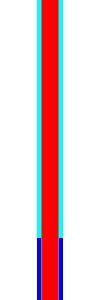

In [6]:
# Create plot
geometry.export_to_xml()
material.export_to_xml()
plot = openmc.Plot.from_geometry(geometry)
plot.basis = 'xz'
plot.width = (5,200)
plot.pixels = (100,300)
plot.color_by = 'material'
plot.colors = {uo2:'red', helium:'cyan', borated_water: 'blue', zircaloy: 'gray'}
openmc.plot_inline(plot)

Let's now build and run a standard depletion calculation, increasing the thermal power to $100\ kW$. The results will be used as the reference to compare with MSR capabilities:

In [7]:
chain_file = '/home/lorenzo/ca_depletion_chains/chain_simple.xml'
op = openmc.deplete.CoupledOperator(model, chain_file)
# Perform simulation using the predictor algorithm
time_steps = [1.0, 1.0, 1.0, 1.0, 1.0]  # days
power = 1.0e5  # W
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading H1 from /home/lorenzo/nuclear_data/endfb80_hdf5/H1.h5
 Reading H2 from /home/lorenzo/nuclear_data/endfb80_hdf5/H2.h5
 Reading c_H_in_H2O from /home/lorenzo/nuclear_data/endfb80_hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000.0
 Reading I135 from /home/lorenzo/nuclear_data/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd156.h5
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====

       31/1    1.03796    0.98811 +/- 0.00986
       32/1    1.00792    0.98901 +/- 0.00945
       33/1    1.01560    0.99017 +/- 0.00910
       34/1    0.97542    0.98955 +/- 0.00873
       35/1    1.03550    0.99139 +/- 0.00858
       36/1    0.99861    0.99167 +/- 0.00824
       37/1    1.03519    0.99328 +/- 0.00810
       38/1    1.03522    0.99478 +/- 0.00794
       39/1    0.94513    0.99307 +/- 0.00785
       40/1    0.95485    0.99179 +/- 0.00769
       41/1    1.00991    0.99238 +/- 0.00746
       42/1    1.01708    0.99315 +/- 0.00727
       43/1    0.99529    0.99321 +/- 0.00705
       44/1    1.00211    0.99348 +/- 0.00684
       45/1    1.04104    0.99484 +/- 0.00678
       46/1    0.94688    0.99350 +/- 0.00672
       47/1    0.96143    0.99264 +/- 0.00659
       48/1    0.97538    0.99218 +/- 0.00643
       49/1    0.97715    0.99180 +/- 0.00628
       50/1    1.03357    0.99284 +/- 0.00621
       51/1    0.98455    0.99264 +/- 0.00606
       52/1    1.00337    0.99289 

       83/1    0.93272    0.98137 +/- 0.00474
       84/1    1.00376    0.98168 +/- 0.00468
       85/1    1.00235    0.98195 +/- 0.00463
       86/1    1.06873    0.98309 +/- 0.00471
       87/1    0.98181    0.98308 +/- 0.00465
       88/1    0.93439    0.98245 +/- 0.00463
       89/1    0.96467    0.98223 +/- 0.00457
       90/1    0.93916    0.98169 +/- 0.00455
       91/1    0.98893    0.98178 +/- 0.00449
       92/1    1.00864    0.98211 +/- 0.00445
       93/1    0.97983    0.98208 +/- 0.00440
       94/1    0.93801    0.98155 +/- 0.00437
       95/1    0.97341    0.98146 +/- 0.00432
       96/1    0.97888    0.98143 +/- 0.00427
       97/1    0.97509    0.98136 +/- 0.00422
       98/1    0.98592    0.98141 +/- 0.00418
       99/1    0.97668    0.98135 +/- 0.00413
      100/1    1.03354    0.98193 +/- 0.00412
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 se

[openmc.deplete] t=345600.0 s, dt=86400.0 s, source=100000.0
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.59386
        2/1    0.69696
        3/1    0.77062
        4/1    0.86882
        5/1    0.92647
        6/1    1.00861
        7/1    0.96018
        8/1    0.99117
        9/1    1.03898
       10/1    0.95815
       11/1    1.01929
       12/1    0.92974    0.97452 +/- 0.04477
       13/1    0.97763    0.97556 +/- 0.02587
       14/1    0.94831    0.96875 +/- 0.01952
       15/1    1.02163    0.97932 +/- 0.01845
       16/1    1.01315    0.98496 +/- 0.01609
       17/1    1.03485    0.99209 +/- 0.01535
       18/1    1.00738    0.99400 +/- 0.01343
       19/1    0.98837    0.99337 +/- 0.01186
       20/1    1.01030    0.99507 +/- 0.01074
       21/1    0.9

       47/1    0.99144    0.97584 +/- 0.00657
       48/1    0.99985    0.97647 +/- 0.00642
       49/1    0.91960    0.97501 +/- 0.00642
       50/1    0.98924    0.97537 +/- 0.00627
       51/1    0.99762    0.97591 +/- 0.00614
       52/1    0.95463    0.97540 +/- 0.00601
       53/1    0.99833    0.97594 +/- 0.00590
       54/1    0.99572    0.97639 +/- 0.00578
       55/1    0.98690    0.97662 +/- 0.00565
       56/1    0.98701    0.97685 +/- 0.00553
       57/1    0.96785    0.97665 +/- 0.00542
       58/1    0.97402    0.97660 +/- 0.00530
       59/1    1.03840    0.97786 +/- 0.00535
       60/1    0.96112    0.97753 +/- 0.00525
       61/1    0.99225    0.97781 +/- 0.00515
       62/1    0.95890    0.97745 +/- 0.00507
       63/1    0.97827    0.97747 +/- 0.00497
       64/1    0.99717    0.97783 +/- 0.00489
       65/1    0.95295    0.97738 +/- 0.00482
       66/1    0.93231    0.97657 +/- 0.00480
       67/1    0.93756    0.97589 +/- 0.00477
       68/1    0.96434    0.97569 

We can now analazie the depletion results:

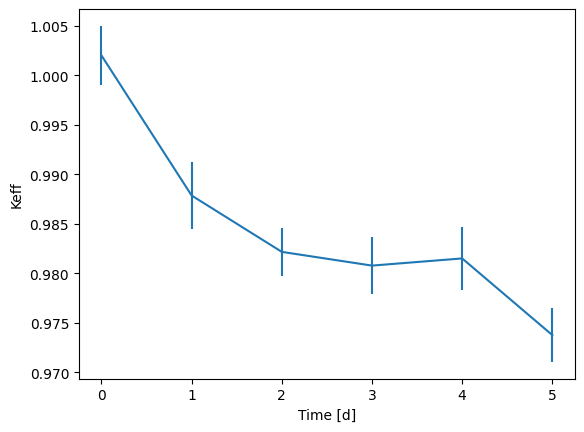

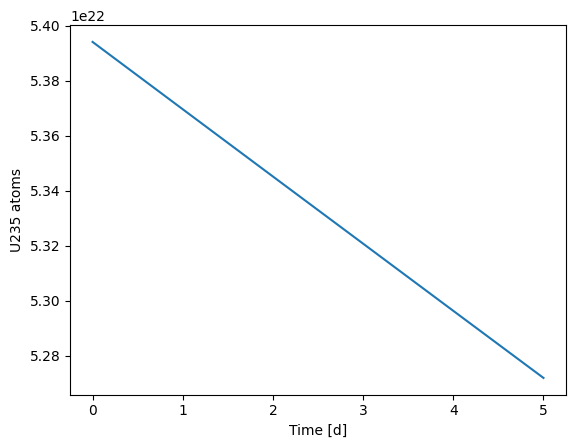

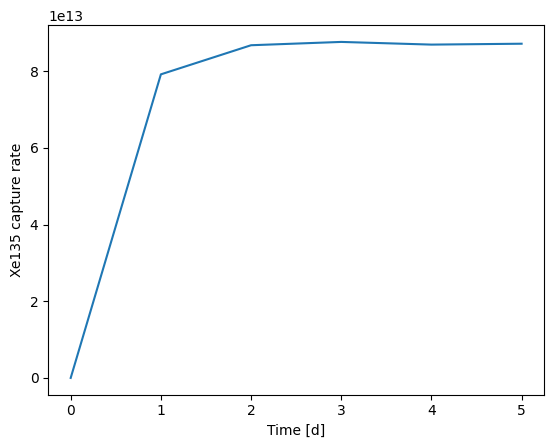

In [8]:
# Open results file
results = openmc.deplete.Results("depletion_results.h5")

# Obtain K_eff as a function of time
time, keff = results.get_keff(time_units='d')

# Obtain U235 concentration as a function of time
_, n_U235 = results.get_atoms(uo2, 'U235')

# Obtain Xe135 capture reaction rate as a function of time
_, Xe_capture = results.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')

# Generate plots
fig, ax = plt.subplots()
ax.errorbar(time, keff[:, 0], keff[:, 1], label="K-effective")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Keff")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, n_U235, label="U235")
ax.set_xlabel("Time [d]")
ax.set_ylabel("U235 atoms")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, Xe_capture, label="Xe135 capture")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Xe135 capture rate")
plt.show()

Let's now introduce the concept of `continuous removal rate` at which some nuclides/elements get removed from the depletable materials, as an additional proportional term to the Bateman equations. This concept assumes first-order removal and homegeneous distributions of the fission products (or elements to removed) throughout the material.

$ \frac{dn_i(t)}{dt} = \underbrace{\sum_j \gamma_{j\rightarrow i} n_j\overline{\sigma_j\phi} - n_i \overline{\sigma_i \phi}}_\textbf{R}  + \underbrace{\sum_j \gamma_{j\rightarrow i} n_j\lambda_{i\rightarrow j} + \lambda_{j\rightarrow i}n_i}_\textbf{D} - \underbrace{\epsilon_i \lambda_i n_i}_\textbf{T}$

Where $ \epsilon_i \lambda_i n_i $ is the removal term, and:

- $\epsilon_i$ is the removal efficiency 

- $\lambda_i$ is the removal rate coefficient for the continuous removal of the nuclide $i$ in ($s^{-1}$)

Another way to characterize $\lambda_i$ is through the concept of cycle time:

$T_{cyc,i} = \frac{1}{\lambda_i}$, as the time needed to process the removal elements at a specific volumetric rate. 

For simplicity, we can combine $\epsilon_i$ and $\lambda_i$ in one single parameter, that we can call again $\lambda_i$. Thus, setting a removal rate coefficient of, for example, $1\ (s^{-1})$ at $100\ \%$ efficiency is the same as setting $10\ (s^{-1})$ at $10\ \%$.

A new depletion matrix can be built as: 

$\frac{d\vec{n}}{dt} = \underbrace{(\textbf{R+D-T})}_\textbf{A}\vec{n} $, 

where:

- $\textbf{R}$ is the reaction rate term
- $\textbf{D}$ is the decay rate term 
- $\textbf{T}$ is the removal rate or transfer term 

That can be solved in a similar fashion. 

Back to our case, let's set a removal rate of $0.1\ (s^{-1})$ for `Xenon` and re-run the the depletion model. 

To do it, we just need to call `openmc.deplete.abc.add_transfer_rate` method from the integrator instance, specifying the depletable material, the elements to remove and a positive transfer rate (if a removal is wanted).

In [13]:
# We need to re-instanciate the operator and the integrator 
op = openmc.deplete.CoupledOperator(model, chain_file)
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.add_transfer_rate('UO2', ['Xe'], 0.1)
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading H1 from /home/lorenzo/nuclear_data/endfb80_hdf5/H1.h5
 Reading H2 from /home/lorenzo/nuclear_data/endfb80_hdf5/H2.h5
 Reading c_H_in_H2O from /home/lorenzo/nuclear_data/endfb80_hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000.0
 Reading I135 from /home/lorenzo/nuclear_data/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd156.h5
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SI

       31/1    0.96966    1.00778 +/- 0.00597
       32/1    1.00985    1.00788 +/- 0.00569
       33/1    1.04429    1.00946 +/- 0.00567
       34/1    1.00828    1.00941 +/- 0.00543
       35/1    1.00762    1.00934 +/- 0.00520
       36/1    0.95013    1.00706 +/- 0.00549
       37/1    1.03504    1.00810 +/- 0.00539
       38/1    1.02835    1.00882 +/- 0.00524
       39/1    0.97196    1.00755 +/- 0.00521
       40/1    1.03495    1.00846 +/- 0.00512
       41/1    1.05970    1.01012 +/- 0.00522
       42/1    1.01196    1.01018 +/- 0.00506
       43/1    1.00514    1.01002 +/- 0.00490
       44/1    0.98868    1.00939 +/- 0.00480
       45/1    1.02890    1.00995 +/- 0.00469
       46/1    0.93557    1.00789 +/- 0.00501
       47/1    0.99516    1.00754 +/- 0.00488
       48/1    1.00930    1.00759 +/- 0.00475
       49/1    0.97895    1.00685 +/- 0.00468
       50/1    1.02493    1.00731 +/- 0.00459
       51/1    1.02320    1.00769 +/- 0.00449
       52/1    1.02420    1.00809 

       78/1    1.01238    0.99773 +/- 0.00573
       79/1    1.02939    0.99819 +/- 0.00567
       80/1    0.99823    0.99819 +/- 0.00559
       81/1    0.98592    0.99802 +/- 0.00551
       82/1    0.98554    0.99784 +/- 0.00544
       83/1    1.00484    0.99794 +/- 0.00536
       84/1    0.96650    0.99751 +/- 0.00531
       85/1    1.00818    0.99766 +/- 0.00524
       86/1    0.91622    0.99658 +/- 0.00528
       87/1    1.03680    0.99711 +/- 0.00523
       88/1    0.96331    0.99667 +/- 0.00519
       89/1    0.95923    0.99620 +/- 0.00514
       90/1    0.94722    0.99559 +/- 0.00511
       91/1    1.04571    0.99621 +/- 0.00509
       92/1    0.95899    0.99575 +/- 0.00505
       93/1    1.02795    0.99614 +/- 0.00500
       94/1    0.92383    0.99528 +/- 0.00501
       95/1    0.95307    0.99478 +/- 0.00498
       96/1    0.94838    0.99424 +/- 0.00495
       97/1    0.99660    0.99427 +/- 0.00489
       98/1    1.00762    0.99442 +/- 0.00484
       99/1    0.98249    0.99429 

[openmc.deplete] t=345600.0 s, dt=86400.0 s, source=100000.0
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.60699
        2/1    0.76296
        3/1    0.75272
        4/1    0.87323
        5/1    1.00364
        6/1    0.92767
        7/1    0.92589
        8/1    1.00999
        9/1    1.00815
       10/1    0.99924
       11/1    0.91196
       12/1    0.99564    0.95380 +/- 0.04184
       13/1    1.01825    0.97528 +/- 0.03233
       14/1    1.00696    0.98320 +/- 0.02419
       15/1    1.06043    0.99865 +/- 0.02428
       16/1    0.98133    0.99576 +/- 0.02004
       17/1    0.98466    0.99418 +/- 0.01701
       18/1    1.04730    1.00082 +/- 0.01616
       19/1    0.95391    0.99561 +/- 0.01517
       20/1    0.95923    0.99197 +/- 0.01405
       21/1    0.9

       52/1    0.99612    0.99609 +/- 0.00534
       53/1    1.03349    0.99696 +/- 0.00529
       54/1    1.00859    0.99723 +/- 0.00517
       55/1    1.01775    0.99768 +/- 0.00508
       56/1    0.92832    0.99617 +/- 0.00519
       57/1    0.93116    0.99479 +/- 0.00526
       58/1    1.02899    0.99550 +/- 0.00520
       59/1    0.99388    0.99547 +/- 0.00509
       60/1    1.03489    0.99626 +/- 0.00505
       61/1    0.97515    0.99584 +/- 0.00497
       62/1    0.98673    0.99567 +/- 0.00488
       63/1    0.93810    0.99458 +/- 0.00491
       64/1    1.03245    0.99528 +/- 0.00487
       65/1    0.98606    0.99512 +/- 0.00478
       66/1    1.00775    0.99534 +/- 0.00470
       67/1    0.96381    0.99479 +/- 0.00465
       68/1    1.13116    0.99714 +/- 0.00514
       69/1    0.99263    0.99706 +/- 0.00505
       70/1    1.06626    0.99822 +/- 0.00510
       71/1    0.94620    0.99736 +/- 0.00508
       72/1    0.97634    0.99703 +/- 0.00501
       73/1    1.04282    0.99775 

Let's open the results and plot them again:

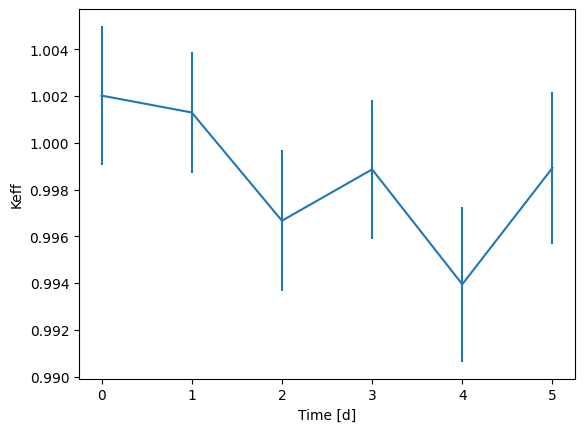

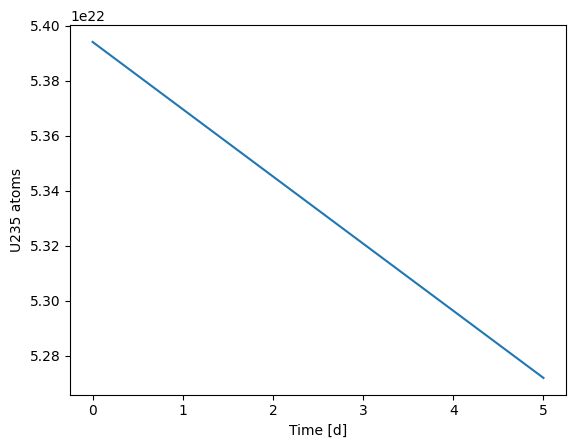

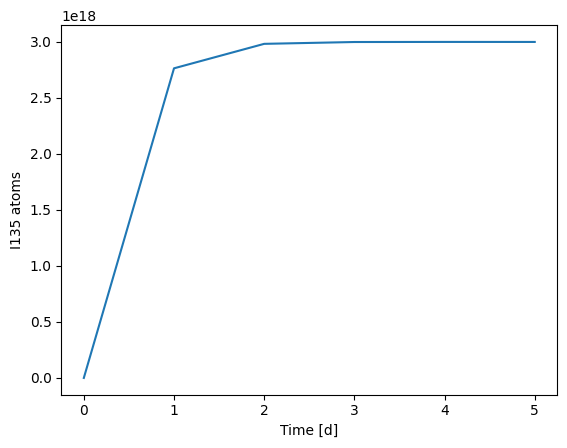

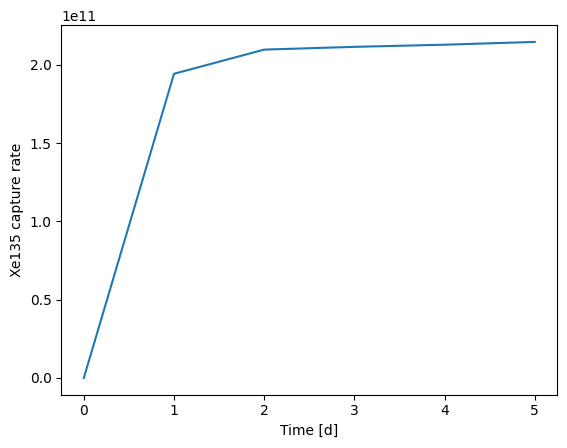

In [14]:
results = openmc.deplete.Results("depletion_results.h5")
time, keff = results.get_keff(time_units='d')
_, n_U235 = results.get_atoms(uo2, 'U235')
_, n_I135 = results.get_atoms(uo2, 'I135')
_, Xe_capture = results.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')

fig, ax = plt.subplots()
ax.errorbar(time, keff[:, 0], keff[:, 1], label="K-effective")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Keff")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, n_U235, label="U235")
ax.set_xlabel("Time [d]")
ax.set_ylabel("U235 atoms")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, n_I135, label="I135")
ax.set_xlabel("Time [d]")
ax.set_ylabel("I135 atoms")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, Xe_capture, label="Xe135 capture")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Xe135 capture rate")
plt.show()

As we can notice, `Xe135` capture rate has reduced indicating that the removal has worked, and consequently `keff` is kept almost constantly. 

Let's now show the capability of the `batchwise`control instead. We want to apply single actions in time to the system to fulfill some objectives, such as maintain a certain level of criticality. The current `batchwise` implementation allows the user to define `geometry-based`or `material-based`actions. 

Back to our example, let's assume we want to maintain $k_{eff}$ close to its initial value $(\sim 1.00 )$ during the whole depletion time, by dynamically increasing the quantity of borated water that acts as moderator and compensates for the neutrons capture of the fission products build-up. 

The `msr` cell that was previously defined and filled with an universe containing borated water and helium gas, can translate up and down, increasing and decreasing the borated water cell volume, respectively. The `geometry-based` algorithm will run a `search_for_keff` at every depletion time-step to find a new interface geometrical coefficient that fulfills the target condition.  

To create a batchwise control, we need to call `openmc.deplete.abc.add_batchwise` method from the integrator instance.
We can, for example, define a batchwise geometrical control with the following arguments:
- type = `trans` : sets type of `batchiwse` control, where `trans` stands for translation
- cell_id_or_name = `MSR` : sets the parametrized cell 
- axis = 2 : sets the cell translation on the z-axis
- bracket = [-2,2]: sets `search_for_keff` bracket to $\pm2\ cm$ from the initial or previous iteration geometrical coefficient. 
- bracket_limit = [-100,100] : sets the limit to the iterative adaptive bracket method to the pincell lower and upper bound.  
- tol = 0.01 : sets `search_for_keff` tolerance 
- target = 1.0 : sets `search_for_keff` target


In [15]:
# We need again to re-instanciate the operator and the integrator 
op = openmc.deplete.CoupledOperator(model, chain_file)
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.add_batchwise('trans', axis = 2, cell_id_or_name = 'MSR',
                          bracket = [-2, 2],
                          bracket_limit = [-100,100],
                          tol = 0.1,
                          target = 1.0)
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000.0
 Reading I135 from /home/lorenzo/nuclear_data/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd156.h5
Iteration: 1; Guess of -2.00e+00 produced a keff of 0.99312 +/- 0.00274
Iteration: 2; Guess of 2.00e+00 produced a keff of 1.01387 +/- 0.00285
Iteration: 3; Guess of -6.74e-01 produced a keff of 0.99694 +/- 0.00314
Iteration: 4; Guess of 1.95e-01 produced a keff of 1.00564 +/- 0.00328
Iteration: 5; Guess of -3.68e-01 produced a keff of

By looking at the output, we  can notice that when `search_for_keff` bracket goes off target, the method iteratively adapts it. 

Again, let's analyse the results:

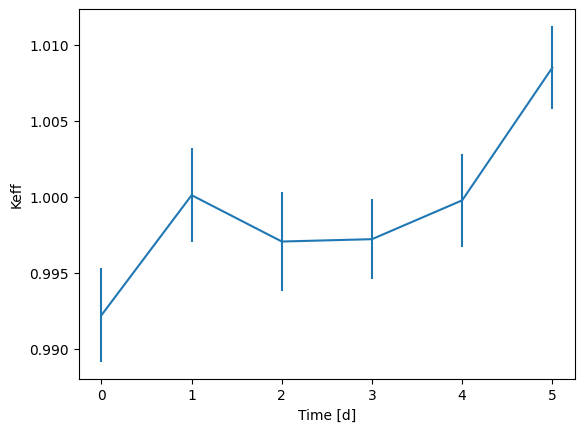

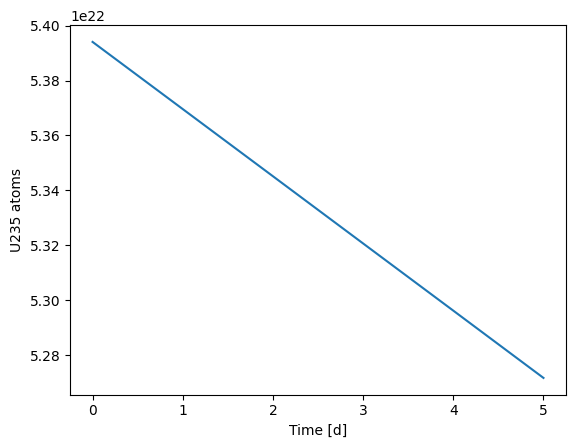

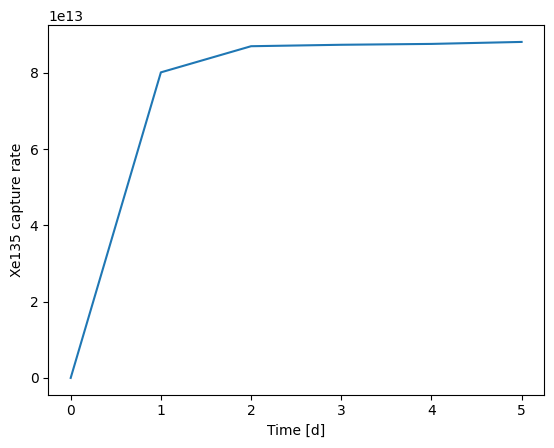

In [16]:
results = openmc.deplete.Results("depletion_results.h5")
time, keff = results.get_keff(time_units='d')
_, n_U235 = results.get_atoms(uo2, 'U235')
_, Xe_capture = results.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')

fig, ax = plt.subplots()
ax.errorbar(time, keff[:, 0], keff[:, 1], label="K-effective")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Keff")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, n_U235, label="U235")
ax.set_xlabel("Time [d]")
ax.set_ylabel("U235 atoms")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, Xe_capture, label="Xe135 capture")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Xe135 capture rate")
plt.show()

As we can see, $k_{eff} \sim 1$ is kept (within statistical uncertainity), even though `Xe135`(main absorber) doesn't get removed (we didn't define any removal rates in this case). This is achieved through the raise of the water level, as we can notice by plotting the results stored in `msr_results.h5`:

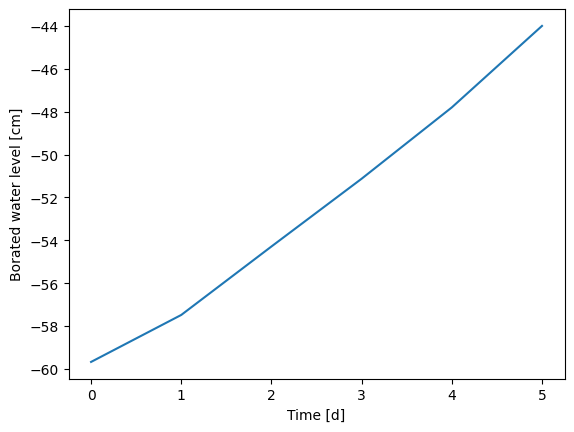

In [18]:
# To open the h5 file we need some imports
import h5py
import numpy as np
h = h5py.File('msr_results.h5','r')
vals = [] 
for key in h.keys():
    vals.append(np.array(h.get(key)))
fig, ax = plt.subplots()
# Offset the values by 59cm, our initial water level height
vals = np.cumsum(vals) - 59
ax.plot(time, vals)
ax.set_xlabel("Time [d]")
ax.set_ylabel("Borated water level [cm]")
plt.show()